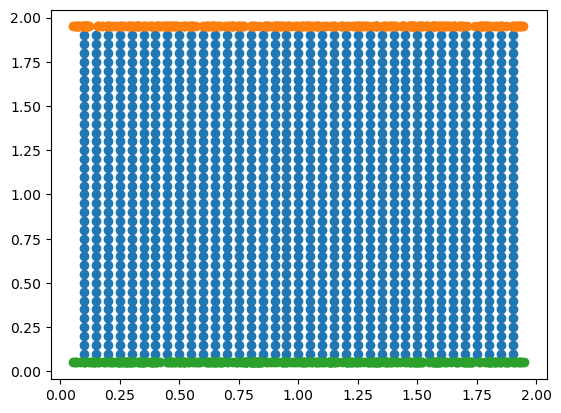

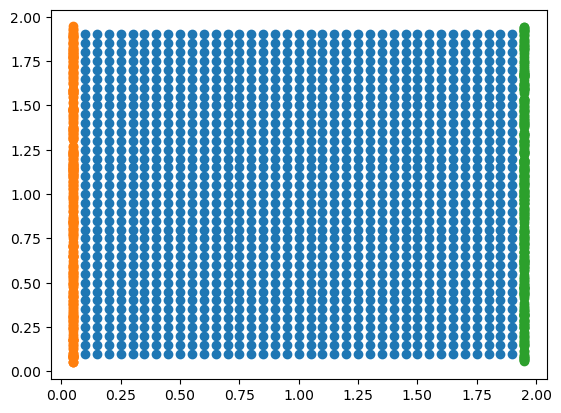

In [1]:
import sys
sys.path.append('../')

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import matplotlib

from user_funn.field import D2Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.geom import line_sample
import user_funn.plot
from user_funn.get_net import DataNetwork

np.random.seed(1)
torch.manual_seed(1)
# STEP1 data generate
batch_num = 1 #ATTENSION: error calculate batch_size when batch_num != 1
nx = 41

field = D2Field([0,2],[0,2])
pde_batch_size = (nx-2) * (nx-2) 
pde_epoch_size = pde_batch_size * batch_num
pde_input = field.get_field_mesh([nx,nx])
filter = [True if (0.09<=item[0]<=1.91 and 0.09<=item[1]<=1.91) else False \
    for item in pde_input ]
pde_input = pde_input[filter]
pde_output = np.zeros([pde_epoch_size,3])

"""
bc_uv_zero[...]
bc_dpdx_zero[...]: left + right
bc_dpdy_zero[...]: up + down
"""

each_line_batch_point = nx * 8 #每条边上用点数量
each_line_point = each_line_batch_point * batch_num

bc_left_input = line_sample([0.05,0.05], [0.05,1.95], each_line_point)
bc_up_input = line_sample([0.05,1.95], [1.95,1.95], each_line_point)
bc_right_input = line_sample([1.95,1.95], [1.95,0.05], each_line_point)
bc_down_input = line_sample([1.95,0.05], [0.05,0.05], each_line_point)

bc_up_output = np.zeros([bc_up_input.shape[0], 3])
bc_down_output = np.zeros([bc_down_input.shape[0], 3])
bc_left_output = np.zeros([bc_left_input.shape[0], 3])
bc_right_output = np.zeros([bc_right_input.shape[0], 3])

bc_up_batchsize = bc_up_input.shape[0]
bc_down_batchsize = bc_down_input.shape[0]
bc_left_batchsize = bc_left_input.shape[0]
bc_right_batchsize = bc_right_input.shape[0] 

user_funn.plot.scatter_2d_cloud_point_kind([pde_input,
    bc_up_input, bc_down_input])

user_funn.plot.scatter_2d_cloud_point_kind([pde_input,
    bc_left_input, bc_right_input])

# 添加
bd_left_input = line_sample([0,0.05], [0,1.95], each_line_point)
bd_up_input = line_sample([0.1,2], [1.9,2], each_line_point)
bd_right_input = line_sample([2,1.95], [2,0.05], each_line_point)
bd_down_input = line_sample([1.95,0], [0.05,0], each_line_point)

bd_uv_zero_input = np.vstack([bd_left_input, bd_down_input, bd_right_input])
bd_uv_up_input = bd_up_input 

bd_uv_zero_output = np.zeros([bd_uv_zero_input.shape[0], 2])
bd_uv_up_output = np.zeros([bd_uv_up_input.shape[0], 2])
bd_uv_up_output[:,0] = 1

bd_uv_zero_batchsize = bd_uv_zero_input.shape[0]
bd_uv_up_batchsize = bd_uv_up_input.shape[0]

In [2]:
loss_fn = torch.nn.MSELoss()

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

DX = 0.05
def pde_loss(model, data):
    x_in,y_real = data
    U = model(x_in)

    # 点赋值
    center_U = U[0,:,:]
    up_U = U[1,:,:]
    down_U = U[2,:,:]
    left_U = U[3,:,:]
    right_U = U[4,:,:]
    # 物理量
    p = center_U[:,0]
    u = center_U[:,1]
    v = center_U[:,2]
    # 导数计算
    dUdx = (right_U - left_U)/(DX*2)
    dUdy = (up_U - down_U)/(DX*2)
    d2Udx2 = (left_U - 2*center_U + right_U)/(DX*DX)
    d2Udy2 = (up_U - 2*center_U + down_U)/(DX*DX)
    # 一阶导
    dpdx = dUdx[:,0]
    dpdy = dUdy[:,0]
    dudx = dUdx[:,1]
    dudy = dUdy[:,1]
    dvdx = dUdx[:,2]
    dvdy = dUdy[:,2]
    # 二阶导
    d2pdx2 = d2Udx2[:,0]
    d2pdy2 = d2Udy2[:,0]
    d2udx2 = d2Udx2[:,1]
    d2udy2 = d2Udy2[:,1]
    d2vdx2 = d2Udx2[:,2]
    d2vdy2 = d2Udy2[:,2]

    eq1 = u*dudx + v*dudy + dpdx - 0.01*(d2udx2 + d2udy2)
    eq2 = u*dvdx + v*dvdy + dpdy - 0.01*(d2vdx2 + d2vdy2)
    eq3 = dudx + dvdy
    
    loss_val = loss_fn(eq1, y_real[:,0]).sqrt() + loss_fn(eq2, y_real[:,1]).sqrt() + \
        loss_fn(eq3, y_real[:,2]).sqrt()
    return loss_val

def bc_up_loss(model, data):
    x_in,y_real = data
    U = model(x_in)

    # 点赋值
    center_U = U[0,:,:]
    up_U = U[1,:,:]
    #up change begin: u = 1 ,v = 0  dpdy = 0
    up_U[:,1] = 1
    up_U[:,2] = 0
    #up change end
    down_U = U[2,:,:]
    left_U = U[3,:,:]
    right_U = U[4,:,:]

    # 物理量
    p = center_U[:,0]
    u = center_U[:,1]
    v = center_U[:,2]

    # 导数计算
    dUdx = (right_U - left_U)/(DX*2)
    dUdy = (up_U - down_U)/(DX*2)
    d2Udx2 = (left_U - 2*center_U + right_U)/(DX*DX)
    d2Udy2 = (up_U - 2*center_U + down_U)/(DX*DX)
    # 一阶导
    dpdx = dUdx[:,0]
    dpdy = dUdy[:,0]
    dudx = dUdx[:,1]
    dudy = dUdy[:,1]
    dvdx = dUdx[:,2]
    dvdy = dUdy[:,2]

    #up change begin: u = 1 ,v = 0  dpdy = 0
    dpdy = 0
    #up change end

    # 二阶导
    d2pdx2 = d2Udx2[:,0]
    d2pdy2 = d2Udy2[:,0]
    d2udx2 = d2Udx2[:,1]
    d2udy2 = d2Udy2[:,1]
    d2vdx2 = d2Udx2[:,2]
    d2vdy2 = d2Udy2[:,2]

    eq1 = u*dudx + v*dudy + dpdx - 0.01*(d2udx2 + d2udy2)
    eq2 = u*dvdx + v*dvdy + dpdy - 0.01*(d2vdx2 + d2vdy2)
    eq3 = dudx + dvdy
    
    loss_val = loss_fn(eq1, y_real[:,0]).sqrt() + loss_fn(eq2, y_real[:,1]).sqrt() + \
        loss_fn(eq3, y_real[:,2]).sqrt()
    return loss_val

def bc_down_loss(model, data):
    x_in,y_real = data
    U = model(x_in)

    # 点赋值
    center_U = U[0,:,:]
    up_U = U[1,:,:]
    down_U = U[2,:,:]
    #down change begin: u = 1 ,v = 0  dpdy = 0
    down_U[:,1] = 0
    down_U[:,2] = 0
    #down change end
    left_U = U[3,:,:]
    right_U = U[4,:,:]
    # 物理量
    p = center_U[:,0]
    u = center_U[:,1]
    v = center_U[:,2]
    # 导数计算
    dUdx = (right_U - left_U)/(DX*2)
    dUdy = (up_U - down_U)/(DX*2)
    d2Udx2 = (left_U - 2*center_U + right_U)/(DX*DX)
    d2Udy2 = (up_U - 2*center_U + down_U)/(DX*DX)
    # 一阶导
    dpdx = dUdx[:,0]
    dpdy = dUdy[:,0]
    dudx = dUdx[:,1]
    dudy = dUdy[:,1]
    dvdx = dUdx[:,2]
    dvdy = dUdy[:,2]

    #down change begin: u = 1 ,v = 0  dpdy = 0
    dpdy = 0
    #down change end

    # 二阶导
    d2pdx2 = d2Udx2[:,0]
    d2pdy2 = d2Udy2[:,0]
    d2udx2 = d2Udx2[:,1]
    d2udy2 = d2Udy2[:,1]
    d2vdx2 = d2Udx2[:,2]
    d2vdy2 = d2Udy2[:,2]

    eq1 = u*dudx + v*dudy + dpdx - 0.01*(d2udx2 + d2udy2)
    eq2 = u*dvdx + v*dvdy + dpdy - 0.01*(d2vdx2 + d2vdy2)
    eq3 = dudx + dvdy
    
    loss_val = loss_fn(eq1, y_real[:,0]).sqrt() + loss_fn(eq2, y_real[:,1]).sqrt() + \
        loss_fn(eq3, y_real[:,2]).sqrt()
    return loss_val

def bc_left_loss(model, data):
    x_in,y_real = data
    U = model(x_in)

    # 点赋值
    center_U = U[0,:,:]
    up_U = U[1,:,:]
    down_U = U[2,:,:]
    left_U = U[3,:,:]
    #left change begin: u = 0 ,v = 0  dpdx = 0
    left_U[:,0] = center_U[:,0]
    left_U[:,1] = 0
    left_U[:,2] = 0
    #left change end
    right_U = U[4,:,:]
    # 物理量
    p = center_U[:,0]
    u = center_U[:,1]
    v = center_U[:,2]
    # 导数计算
    dUdx = (right_U - left_U)/(DX*2)
    dUdy = (up_U - down_U)/(DX*2)
    d2Udx2 = (left_U - 2*center_U + right_U)/(DX*DX)
    d2Udy2 = (up_U - 2*center_U + down_U)/(DX*DX)
    # 一阶导
    dpdx = dUdx[:,0]
    dpdy = dUdy[:,0]
    dudx = dUdx[:,1]
    dudy = dUdy[:,1]
    dvdx = dUdx[:,2]
    dvdy = dUdy[:,2]
    #left change begin: u = 1 ,v = 0  dpdy = 0
    dpdx = 0
    #left change end
    # 二阶导
    d2pdx2 = d2Udx2[:,0]
    d2pdy2 = d2Udy2[:,0]
    d2udx2 = d2Udx2[:,1]
    d2udy2 = d2Udy2[:,1]
    d2vdx2 = d2Udx2[:,2]
    d2vdy2 = d2Udy2[:,2]

    eq1 = u*dudx + v*dudy + dpdx - 0.01*(d2udx2 + d2udy2)
    eq2 = u*dvdx + v*dvdy + dpdy - 0.01*(d2vdx2 + d2vdy2)
    eq3 = dudx + dvdy
    
    loss_val = loss_fn(eq1, y_real[:,0]).sqrt() + loss_fn(eq2, y_real[:,1]).sqrt() + \
        loss_fn(eq3, y_real[:,2]).sqrt()
    return loss_val

def bc_right_loss(model, data):
    x_in,y_real = data
    U = model(x_in)

    # 点赋值
    center_U = U[0,:,:]
    up_U = U[1,:,:]
    down_U = U[2,:,:]
    left_U = U[3,:,:]
    right_U = U[4,:,:]
    #right change begin: u = 0 ,v = 0  dpdx = 0
    right_U[:,0] = center_U[:,0]
    right_U[:,1] = 0
    right_U[:,2] = 0
    #right change end
    # 物理量
    p = center_U[:,0]
    u = center_U[:,1]
    v = center_U[:,2]
    # 导数计算
    dUdx = (right_U - left_U)/(DX*2)
    dUdy = (up_U - down_U)/(DX*2)
    d2Udx2 = (left_U - 2*center_U + right_U)/(DX*DX)
    d2Udy2 = (up_U - 2*center_U + down_U)/(DX*DX)
    # 一阶导
    dpdx = dUdx[:,0]
    dpdy = dUdy[:,0]
    dudx = dUdx[:,1]
    dudy = dUdy[:,1]
    dvdx = dUdx[:,2]
    dvdy = dUdy[:,2]
    #right change begin: u = 1 ,v = 0  dpdy = 0
    dpdx = 0
    #right change end
    # 二阶导
    d2pdx2 = d2Udx2[:,0]
    d2pdy2 = d2Udy2[:,0]
    d2udx2 = d2Udx2[:,1]
    d2udy2 = d2Udy2[:,1]
    d2vdx2 = d2Udx2[:,2]
    d2vdy2 = d2Udy2[:,2]

    eq1 = u*dudx + v*dudy + dpdx - 0.01*(d2udx2 + d2udy2)
    eq2 = u*dvdx + v*dvdy + dpdy - 0.01*(d2vdx2 + d2vdy2)
    eq3 = dudx + dvdy
    
    loss_val = loss_fn(eq1, y_real[:,0]).sqrt() + loss_fn(eq2, y_real[:,1]).sqrt() + \
        loss_fn(eq3, y_real[:,2]).sqrt()
    return loss_val


def bd_uv_zero_loss(model, data):
    x_in,y_real = data
    U = model(x_in)
    center_U = U[0,:,:]
    u = center_U[:,1]
    v = center_U[:,2]
    return loss_fn(u, y_real[:,0]).sqrt() + loss_fn(v, y_real[:,1]).sqrt()

def bd_uv_up_loss(model, data):
    x_in,y_real = data
    U = model(x_in)
    center_U = U[0,:,:]
    u = center_U[:,1]
    v = center_U[:,2]
    return loss_fn(u, y_real[:,0]).sqrt() + loss_fn(v, y_real[:,1]).sqrt()

cloud_point_data = [
    [pde_input, pde_output],
    [bc_up_input, bc_up_output],
    [bc_down_input, bc_down_output],
    [bc_left_input, bc_left_output],
    [bc_right_input, bc_right_output],
    [bd_uv_zero_input,bd_uv_zero_output],
    [bd_uv_up_input,bd_uv_up_output]
    ]

solver = CloudPointSolver(
    cloud_point_data,
    [pde_loss, bc_up_loss, bc_down_loss, \
        bc_left_loss, bc_right_loss,
        bd_uv_zero_loss, bd_uv_up_loss],
    model = DataNetwork([2, 100, 100, 100, 100, 3]),
    optimizer = "adam",
    batchsize = [pde_batch_size, bc_up_batchsize, bc_down_batchsize,\
        bc_left_batchsize, bc_right_batchsize, \
        bd_uv_zero_batchsize, bd_uv_up_batchsize])

for i in range(30000):
    solver.train_step()
    if i % 1000 == 0:
        solver.test_step(print_flag=True)
print('train over')

loss is [4.70394127e-07 6.46716356e+00 1.30410075e+00 7.00161457e-01
 7.60589957e-01 1.19247817e-01 1.11924779e+00 1.04705105e+01]
loss is [0.31232557 0.42952925 0.003679   0.12753338 0.20900339 0.07686022
 0.14332497 1.3022557 ]
loss is [0.23908572 0.0823957  0.00683946 0.05573943 0.13718799 0.07982943
 0.11241043 0.71348816]
loss is [0.22606242 0.28077108 0.00332586 0.04007412 0.08232392 0.07419557
 0.09842092 0.8051739 ]
loss is [0.21851955 0.1563912  0.00286861 0.02233255 0.05881497 0.06794442
 0.08500652 0.61187786]
loss is [0.20345834 0.25417617 0.00344747 0.02980604 0.06269419 0.06374072
 0.08129131 0.69861424]
loss is [0.19993207 0.2708665  0.00379405 0.02915827 0.05263589 0.05845532
 0.0877993  0.7026415 ]
loss is [0.18768485 0.25920776 0.00630193 0.0235995  0.04931142 0.05005477
 0.0853317  0.66149193]
loss is [0.19532993 0.1916285  0.00462406 0.01776009 0.02849978 0.05414982
 0.0622112  0.5542034 ]
loss is [0.18319108 0.14528655 0.00299988 0.02073227 0.06729154 0.05102215
 0

0.38060546798791955
0.43032516541461824
0.5692736138520195


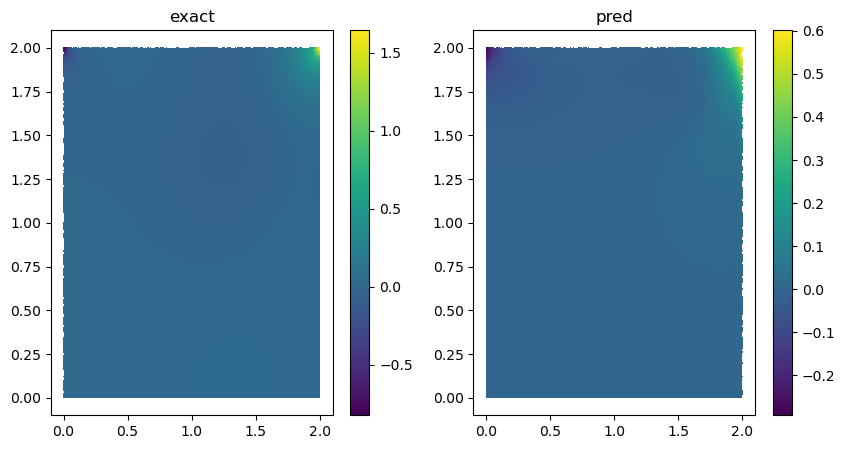

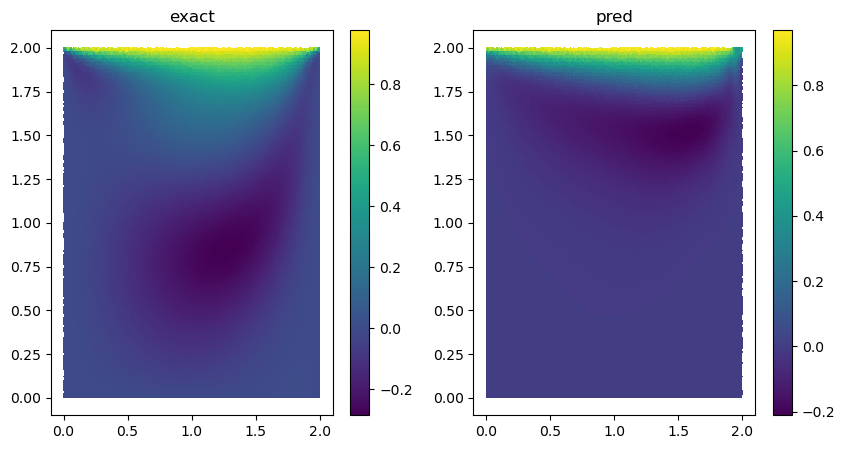

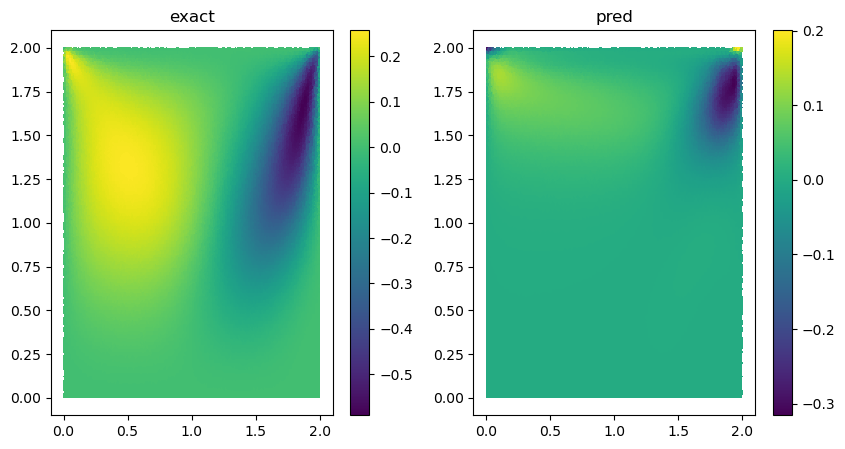

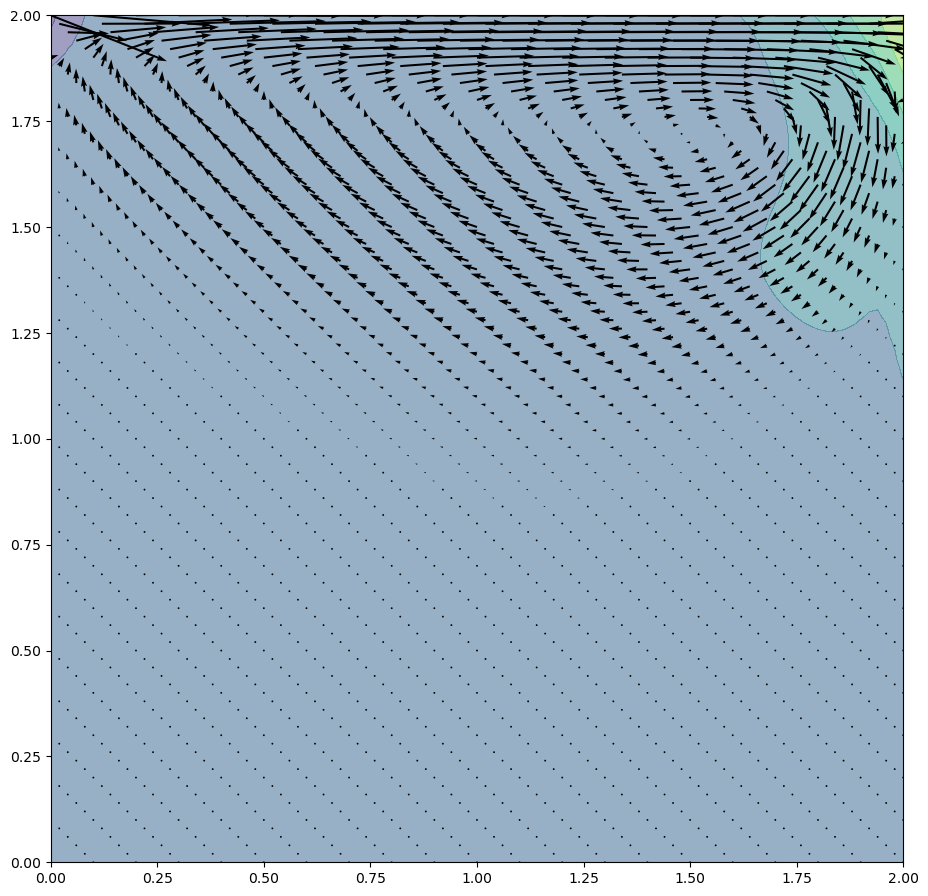

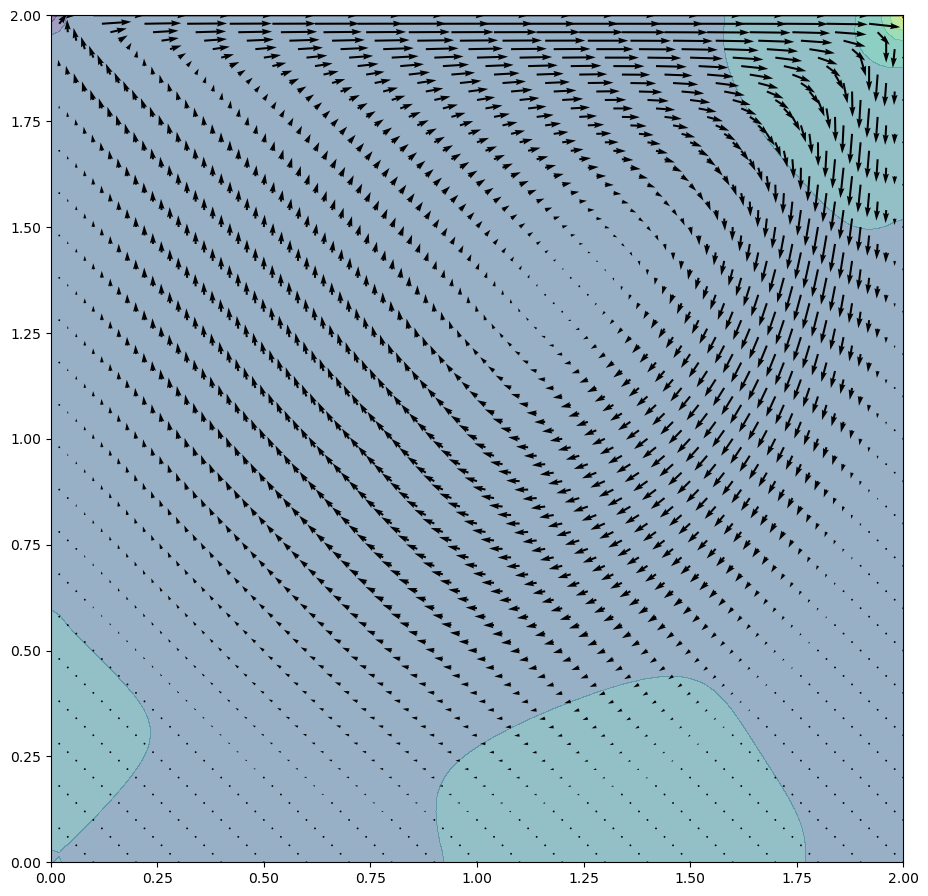

In [3]:
from user_funn.paraview_read import read2D_paraview_csv
exact_x,exact_y,exact_p,exact_u,exact_v=read2D_paraview_csv('../data/t=20,mu=0.01.csv',20)
filter = (exact_x>=0.00) & (exact_x<=2) & (exact_y>=0.00) & (exact_y<=2) 

plot_input = np.array([exact_x,exact_y]).T
plot_output = solver.model_eval(plot_input).detach().cpu().numpy()
plot_p = plot_output[0,:,0]
plot_u = plot_output[0,:,1]
plot_v = plot_output[0,:,2]

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_U(x,y,u_exact,u_pred):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize =[10,5] )

    triang = tri.Triangulation(x,y)
    tpc = ax1.tripcolor(triang,u_exact , shading='flat')
    fig.colorbar(tpc,ax=ax1)
    ax1.set_title('exact')

    tpc = ax2.tripcolor(triang,u_pred , shading='flat')
    fig.colorbar(tpc,ax=ax2)
    ax2.set_title('pred')
    print(np.mean(np.abs(u_exact-u_pred))/np.std(u_exact))

x = plot_input[:,0]
y = plot_input[:,1]
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_p[filter]-np.mean(exact_p), plot_p[filter]-np.mean(plot_p))
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_u[filter], plot_u[filter])
plot_U(plot_input[filter,0], plot_input[filter,1], \
    exact_v[filter], plot_v[filter])

plot_x = plot_input[:,0]
plot_y = plot_input[:,1]
plt.figure(figsize=(11, 11))
plt.tricontourf(plot_x, plot_y, plot_p,alpha=0.5, cmap=cm.viridis)
plt.quiver(plot_x[filter][::5], plot_y[filter][::5],plot_u[filter][::5],plot_v[filter][::5])

plt.figure(figsize=(11, 11))
plt.tricontourf(plot_x, plot_y, exact_p,alpha=0.5, cmap=cm.viridis)
plt.quiver(plot_x[::5], plot_y[::5],exact_u[::5],exact_v[::5])
